### Classification

In [66]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import requests
import zipfile
import io
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [43]:


# Step 1: Define the URL of the zip file
url = "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip"  # Replace with the actual URL of the zip file

# Step 2: Download the zip file and save it
response = requests.get(url)
zip_file_path = Path("data/bank-marketing.zip")

# Save the zip file to the current directory
with open(zip_file_path, "wb") as f:
    f.write(response.content)

# Step 3: Extract the zip file to a folder
extract_folder = Path("data")
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Step 4: Find and extract the inner zip file (bank.zip)
inner_zip_path = Path("data/bank.zip")  # Path to the inner zip file

with zipfile.ZipFile(inner_zip_path, 'r') as inner_zip_ref:
    inner_extract_folder = Path(extract_folder / "bank")
    inner_zip_ref.extractall(inner_extract_folder)

# Step 4: Read the CSV file (assuming there's one CSV in the zip file)
# Replace 'your_file.csv' with the actual file name
csv_file_path = Path(extract_folder / "bank/bank-full.csv")
df = pd.read_csv(csv_file_path, delimiter=';')

# Display the dataframe
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [44]:
features = ['age','job','marital','education','balance','housing','contact','day','month','duration','campaign','pdays','previous','poutcome']
target = ['y']

In [45]:
df[features].isna().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64

Q1) Most frequent observation for education

In [46]:
df['education'].mode().item()

'secondary'

Q2) Correlation matrix

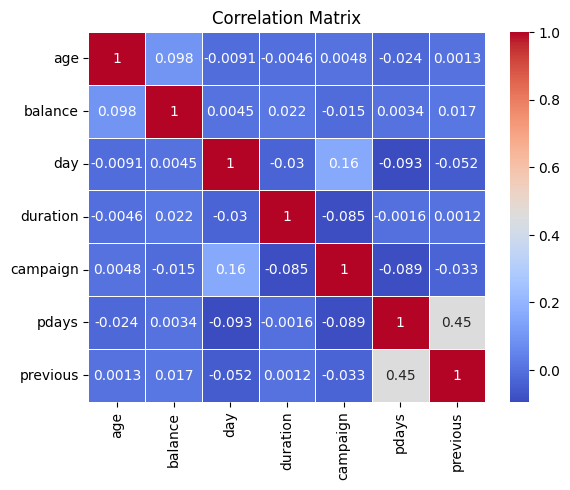

In [47]:
corr = df[features+target].corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm',linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

pdays and previous --- are the features with biggest correlation

In [48]:
df[target] = (df[target] == 'yes').astype(int)
df[target]

,y
0,0
1,0
2,0
3,0
4,0
...,...
45206,1
45207,1
45208,1
45209,0


Split the data

In [49]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=42)

len(df_train), len(df_val), len(df_test)

(28934, 7234, 9043)

In [50]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


In [51]:
df_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,40,blue-collar,married,secondary,no,580,yes,no,unknown,16,may,192,1,-1,0,unknown,0
1,47,services,single,secondary,no,3644,no,no,unknown,9,jun,83,2,-1,0,unknown,0
2,25,student,single,tertiary,no,538,yes,no,cellular,20,apr,226,1,-1,0,unknown,0
3,42,management,married,tertiary,no,1773,no,no,cellular,9,apr,311,1,336,1,failure,0
4,56,management,married,tertiary,no,217,no,yes,cellular,21,jul,121,2,-1,0,unknown,0


In [52]:
y_train = df_train['y'].values
y_val = df_val['y'].values
y_test = df_test['y'].values

del df_train['y']
del df_val['y']
del df_test['y']

In [56]:
# mutual info scores

def mutual_info_scores(series):
    return round(mutual_info_score(series, y_train),2)


In [57]:
categoricals = list(df_train.dtypes[df_train.dtypes =='object'].index)
mi = df_train[categoricals].apply(mutual_info_scores)
mi

job          0.01
marital      0.00
education    0.00
default      0.00
housing      0.01
loan         0.00
contact      0.01
month        0.02
poutcome     0.03
dtype: float64

poutcome has the highest mutual information score

Q4) Modeling

In [90]:
categoricals = ['job',
 'marital',
 'education',
#  'default',
 'housing',
#  'loan',
 'contact',
 'month',
 'poutcome']

In [91]:
df_train.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome'],
      dtype='object')

In [92]:
numerical = ['age','balance','day','duration','campaign','pdays','previous']

In [93]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categoricals + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categoricals + numerical].to_dict(orient="records")
X_val = dv.transform(val_dict)

In [94]:
model = LogisticRegression(solver='liblinear',C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

y_pred_val = model.predict(X_val)

val_accuracy_score = accuracy_score(y_val, y_pred_val)
print(f"Accuracy is {round(val_accuracy_score,2)}")




Accuracy is 0.9


Q5) Feature elimination

In [95]:
scores_dict = {}

scores_dict['feat_none_removed'] = round(val_accuracy_score,2)
orig_acc = val_accuracy_score

for feature in features:
    modelname = f"feat_{feature}_removed"
    # print(f"model for {modelname}")
    featurelist = [col for col in features if col != feature]
    # print(featurelist)

    dv = DictVectorizer(sparse=False)

    train_dict = df_train[featurelist].to_dict(orient="records")
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val[featurelist].to_dict(orient="records")
    X_val = dv.transform(val_dict)

    model = LogisticRegression(solver='liblinear',C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    y_pred_val = model.predict(X_val)

    val_accuracy_score = accuracy_score(y_val, y_pred_val)
    # print(f"Accuracy is {round(val_accuracy_score,2)}")

    scores_dict[modelname] = orig_acc - val_accuracy_score 


In [84]:
scores_dict

{'feat_none_removed': 0.89,
 'feat_age_removed': -0.00815593032900197,
 'feat_job_removed': -0.007464749792645775,
 'feat_marital_removed': -0.008708874758086793,
 'feat_education_removed': -0.007464749792645775,
 'feat_balance_removed': -0.007602985899917036,
 'feat_housing_removed': -0.008847110865358054,
 'feat_contact_removed': -0.007326513685374625,
 'feat_day_removed': -0.008017694221730709,
 'feat_month_removed': -0.005944152612662457,
 'feat_duration_removed': 0.0038706110035942043,
 'feat_campaign_removed': -0.007326513685374625,
 'feat_pdays_removed': -0.008017694221730709,
 'feat_previous_removed': -0.007602985899917036,
 'feat_poutcome_removed': 0.0}

In [96]:

scores_df = pd.DataFrame.from_dict(scores_dict, orient="index", columns=['acc_diff'])
scores_df
    



,acc_diff
feat_none_removed,0.900000
feat_age_removed,-0.000415
feat_job_removed,0.000276
feat_marital_removed,-0.000968
feat_education_removed,0.000276
feat_balance_removed,0.000138
feat_housing_removed,-0.001106
feat_contact_removed,0.000415
feat_day_removed,-0.000276
feat_month_removed,0.001797


age - feature has the smallest difference

In [98]:
C = [0.01, 0.1, 1, 10, 100]

scores_dict = {}

for c in C:
    modelname = f"feat_{c}"
    # print(f"model for {modelname}")

    dv = DictVectorizer(sparse=False)

    train_dict = df_train[features].to_dict(orient="records")
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val[features].to_dict(orient="records")
    X_val = dv.transform(val_dict)

    model = LogisticRegression(solver='liblinear',C=c, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    y_pred_val = model.predict(X_val)

    val_accuracy_score = accuracy_score(y_val, y_pred_val)
    # print(f"Accuracy is {round(val_accuracy_score,2)}")

    scores_dict[modelname] = round(val_accuracy_score,3)

In [99]:
scores_df = pd.DataFrame.from_dict(scores_dict, orient="index", columns=['acc'])
scores_df

,acc
feat_0.01,0.898
feat_0.1,0.900
feat_1,0.901
feat_10,0.901
feat_100,0.901


c = 1 leads to best accuracy on the validation set